<a href="https://colab.research.google.com/github/fawadwazir/python_bio/blob/main/Predicting_Ori_of_bacteria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

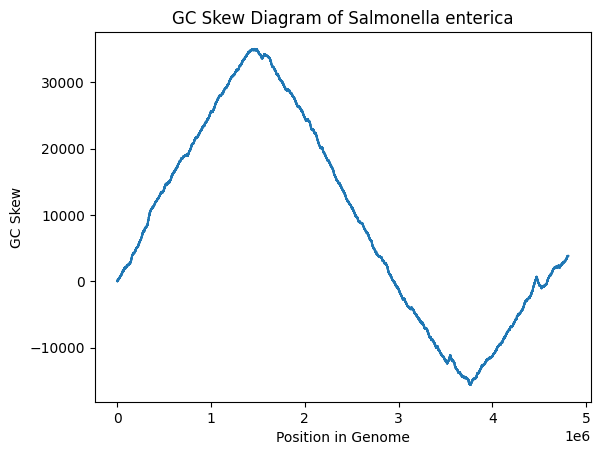

Best Predicted DnaA Box: TTATCCACA (Score: 0 mismatches)


In [26]:
import matplotlib.pyplot as plt
from collections import defaultdict

def reverse_complement(Pattern):
    """Returns the reverse complement of a DNA sequence."""
    complement = {"A": "T", "T": "A", "C": "G", "G": "C"}
    return "".join(complement[nucleotide] for nucleotide in reversed(Pattern))

def hamming_distance(seq1, seq2):
    """Computes the Hamming distance between two sequences."""
    return sum(1 for a, b in zip(seq1, seq2) if a != b)

def generate_neighbors(Pattern, d):
    """Generates all k-mers with at most d mismatches."""
    nucleotides = "ACGT"
    neighbors = set()

    def generate(pattern, mismatches_left, index):
        if mismatches_left == 0 or index == len(pattern):
            neighbors.add(pattern)
            return
        # Mutate current position
        for nucleotide in nucleotides:
            mutated = pattern[:index] + nucleotide + pattern[index + 1:]
            generate(mutated, mismatches_left - (nucleotide != pattern[index]), index + 1)
        # Keep the original
        generate(pattern, mismatches_left, index + 1)

    generate(Pattern, d, 0)
    return neighbors

def frequent_words_with_mismatches(Text, k, d):
    """Finds the most frequent k-mers with mismatches in a given sequence."""
    freqMap = defaultdict(int)
    nucleotides = "ACGT"

    for i in range(len(Text) - k + 1):
        Pattern = Text[i:i + k]
        neighborhood = generate_neighbors(Pattern, d)
        for neighbor in neighborhood:
            freqMap[neighbor] += 1

    max_count = max(freqMap.values())
    frequent_patterns = [kmer for kmer, count in freqMap.items() if count == max_count]

    return frequent_patterns

def score_against_known_motif(kmers, known_motif):
    """Ranks k-mers based on similarity to the known DnaA motif."""
    best_kmer = None
    best_score = float("inf")  # Lower is better

    for kmer in kmers:
        score = hamming_distance(kmer, known_motif)
        if score < best_score:
            best_score = score
            best_kmer = kmer

    return best_kmer, best_score

# Step 1: Load the Salmonella enterica genome
file_path = "Salmonella_enterica.txt"  # Upload the genome file
with open(file_path, "r") as f:
    genome = "".join(line.strip() for line in f if not line.startswith(">"))  # Remove header

# Step 2: Compute the GC skew
def compute_skew(genome):
    skew = [0]
    for nucleotide in genome:
        if nucleotide == "G":
            skew.append(skew[-1] + 1)
        elif nucleotide == "C":
            skew.append(skew[-1] - 1)
        else:
            skew.append(skew[-1])
    return skew

def find_minimum_skew_positions(genome):
    skew_values = compute_skew(genome)
    min_skew = min(skew_values)
    return [i for i, value in enumerate(skew_values) if value == min_skew]

min_skew_positions = find_minimum_skew_positions(genome)

# Step 3: Extract the region around oriC
region_start = max(min_skew_positions[0] - 500, 0)
region_end = min(min_skew_positions[0] + 500, len(genome))
ori_region = genome[region_start:region_end]

# Step 4: Find frequent 9-mers (DnaA box candidates) with mismatches
k = 9  # DnaA box is usually 9 bp long
d = 1  # Allow 1 mismatch
dnaa_boxes = frequent_words_with_mismatches(ori_region, k, d)

# Step 5: Compare with known DnaA box motif
known_dnaa_motif = "TTATCCACA"
best_dnaa_box, score = score_against_known_motif(dnaa_boxes, known_dnaa_motif)

# Step 6: Plot the GC skew diagram
skew_values = compute_skew(genome)
plt.plot(range(len(skew_values)), skew_values)
plt.xlabel("Position in Genome")
plt.ylabel("GC Skew")
plt.title("GC Skew Diagram of Salmonella enterica")
plt.show()

# Step 7: Print the best predicted DnaA Box
print(f"Best Predicted DnaA Box: {best_dnaa_box} (Score: {score} mismatches)")
